In [1]:
import numpy as np, matplotlib.pyplot as plt
import os
from scipy import interpolate
from astropy.convolution import convolve_fft, Gaussian1DKernel
from glob import glob

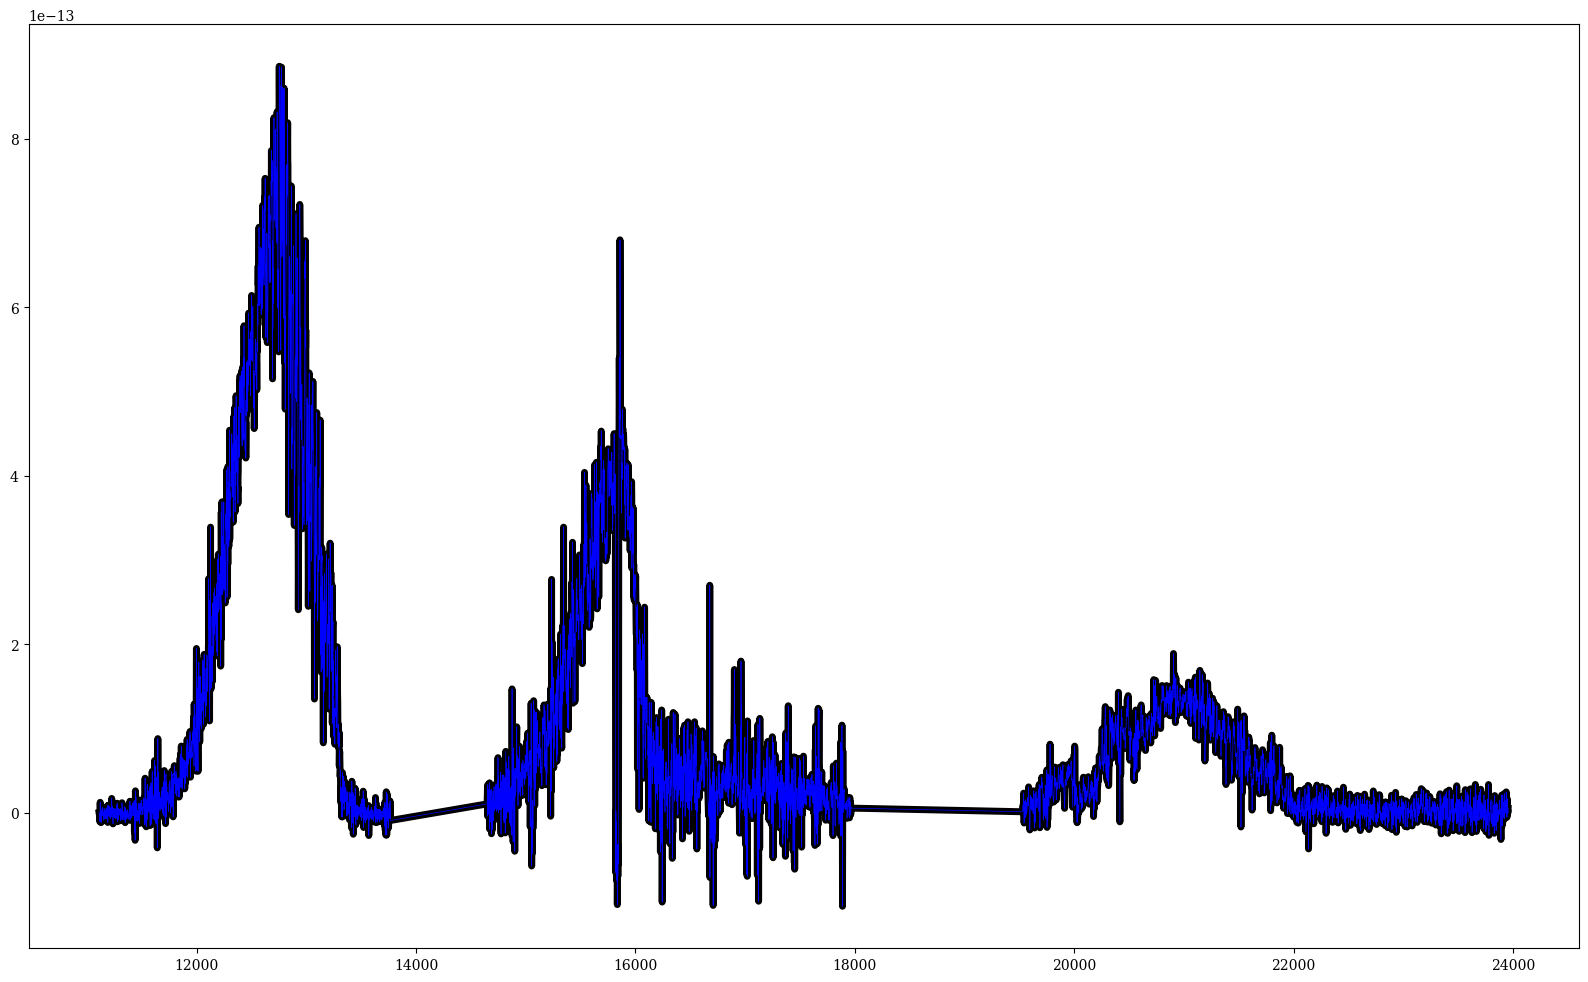

In [278]:
############################################################################################
## Read in the MOSFIRE data and plot the basics                                           ##
## I used both np.loadtxt() and open() to guarantee they did the same thing (they do lol) ##
############################################################################################

msfire = np.loadtxt('Flux_cal_JHK_2M2255-3118_excel.txt')
wave = msfire[:, 0] # Å
wave_um = msfire[:, 0] * 1e-4 # µm
flux = msfire[:, 1]
unc = msfire[:, 2]

with open('Flux_cal_JHK_2M2255-3118_excel.txt', 'r') as f1:
    rows = f1.readlines()

data = []
for row in rows:
    row = row.strip('\n')
    cols = row.split('\t')
    data.append(cols)

w = []
f = []
u = []
for i in range(len(data)):
    w.append(data[i][0])
    f.append(data[i][1])
    u.append(data[i][2])

wave1 = [eval(i) for i in w]
flux1 = [eval(i) for i in f]
unc1 = [eval(i) for i in u]

plt.figure(figsize = (20, 12))
plt.plot(wave, flux, color = 'black', linewidth = 5)
plt.plot(wave1, flux1, color = 'blue', linewidth = 0.5)

In [279]:
########################################################################
## Define all the necessary variables and calculate any needed values ##
########################################################################

target = 'WISE J225540.75-311842.0'
target_short = 'WISE J225540'

file_name = '/Users/bseamons/Documents/Research/Flux_cal_JHK_2M2255-3118.txt'

bt_path = '/Users/bseamons/Documents/Research/models_1717611630/bt-settl_models/'
bt_models = glob(os.path.join(bt_path, '*.7.dat.txt'))

atmo_path = '/Users/bseamons/Documents/Research/atmo_models/'
atmo_models = glob(os.path.join(atmo_path, '*.dat'))

spex_path = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/'
spex_models = glob(os.path.join(spex_path, '*.txt'))

parallax = 0.0704 # arcseconds
r_jup_km = 69911 # km
r_jup_A = r_jup_km * 1e13 # Å
d_ly = 1 / parallax # distance to target, LY
d_km = d_ly * 9.461e12 # distance to target, km
d_A = d_km * 1e13 # distance to target, Å
scale_km = (r_jup_km ** 2) / (d_km ** 2) # scale factor (r ** 2 / d ** 2), km
scale_A = (r_jup_A ** 2) / (d_A ** 2) # scale factor, Å

RJ = 3318
RH = 3660
RK = 3610
R_array = np.array([RJ, RH, RK])
R = np.average(R_array)

print(f'* Target distance in light-years: {d_ly} ly\n* Target distance in kilometers:  {d_km} km\n* Target distance in angstroms:   {d_A} Å\n')
print(f'* Scaling constant (km):          {scale_km}\n* Scaling constant (Å):           {scale_A}\n')
print(f'* Average resolution:             {R}')

* Target distance in light-years: 14.204545454545453 ly
* Target distance in kilometers:  134389204545454.53 km
* Target distance in angstroms:   1.3438920454545454e+27 Å

* Scaling constant (km):          2.7062147816281133e-19
* Scaling constant (Å):           2.7062147816281133e-19

* Average resolution:             3529.3333333333335


In [280]:
def convolve_v2(spec, R, sample):
    '''
    This will convolve a model spectrum with a gaussian kernel to the given resolution of the observations [R].
    * Parameters:
        * spec: source spectrum (the object that will be convolved)
        * R: int (the resolution (dL/L) to convolve to)
        * sample: int (oversampling factor for smoothing)
    * Returns:
        * smooth_spec: the convolved spectrum (and possibly the original grid)
    * Notes:
        * Built to work in tandem with bestfit_[model]()
        * Needs numpy as np and convolve_fft, Gaussian1DKernel from astropy.convolution
    '''
    ## Define the model wavelength and flux grids
    w_grid = spec[0, :]
    f_grid = spec[1, :]

    ## Define a logarithmic wavelength grid
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    N = np.size(w_grid) * sample
    w_loggrid = np.logspace(w_logmin, w_logmax, num = N)

    ## Calculate the standard deviation of the Gaussian kernel
    R_grid = (w_loggrid[1:-1] + w_loggrid[0:-2]) / (w_loggrid[1:-1] - w_loggrid[0:-2]) / 2
    sigma = np.median(R_grid) / R
    if sigma < 1:
        sigma = 1

    ## Interpolate the models onto the log grid, convolve them, and interpolate the results onto the original grid
    f_log = np.interp(w_loggrid, w_grid, f_grid)
    gauss = Gaussian1DKernel(stddev = sigma)
    f_conv = convolve_fft(f_log, gauss)
    f_smooth = np.interp(w_grid, w_loggrid, f_conv)
    smooth_spec = np.vstack([w_grid, f_smooth])

    return smooth_spec

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_25330/2083972615.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex = int(where_Gmin[0])


Minimum C value:         [6.40109879e-20]
Minimum G value:         31627.134866091055
Best fit BT-Settl model: /Users/bseamons/Documents/Research/models_1717611630/bt-settl_models/lte006-3.5-0.0.BT-Settl.7.dat.txt


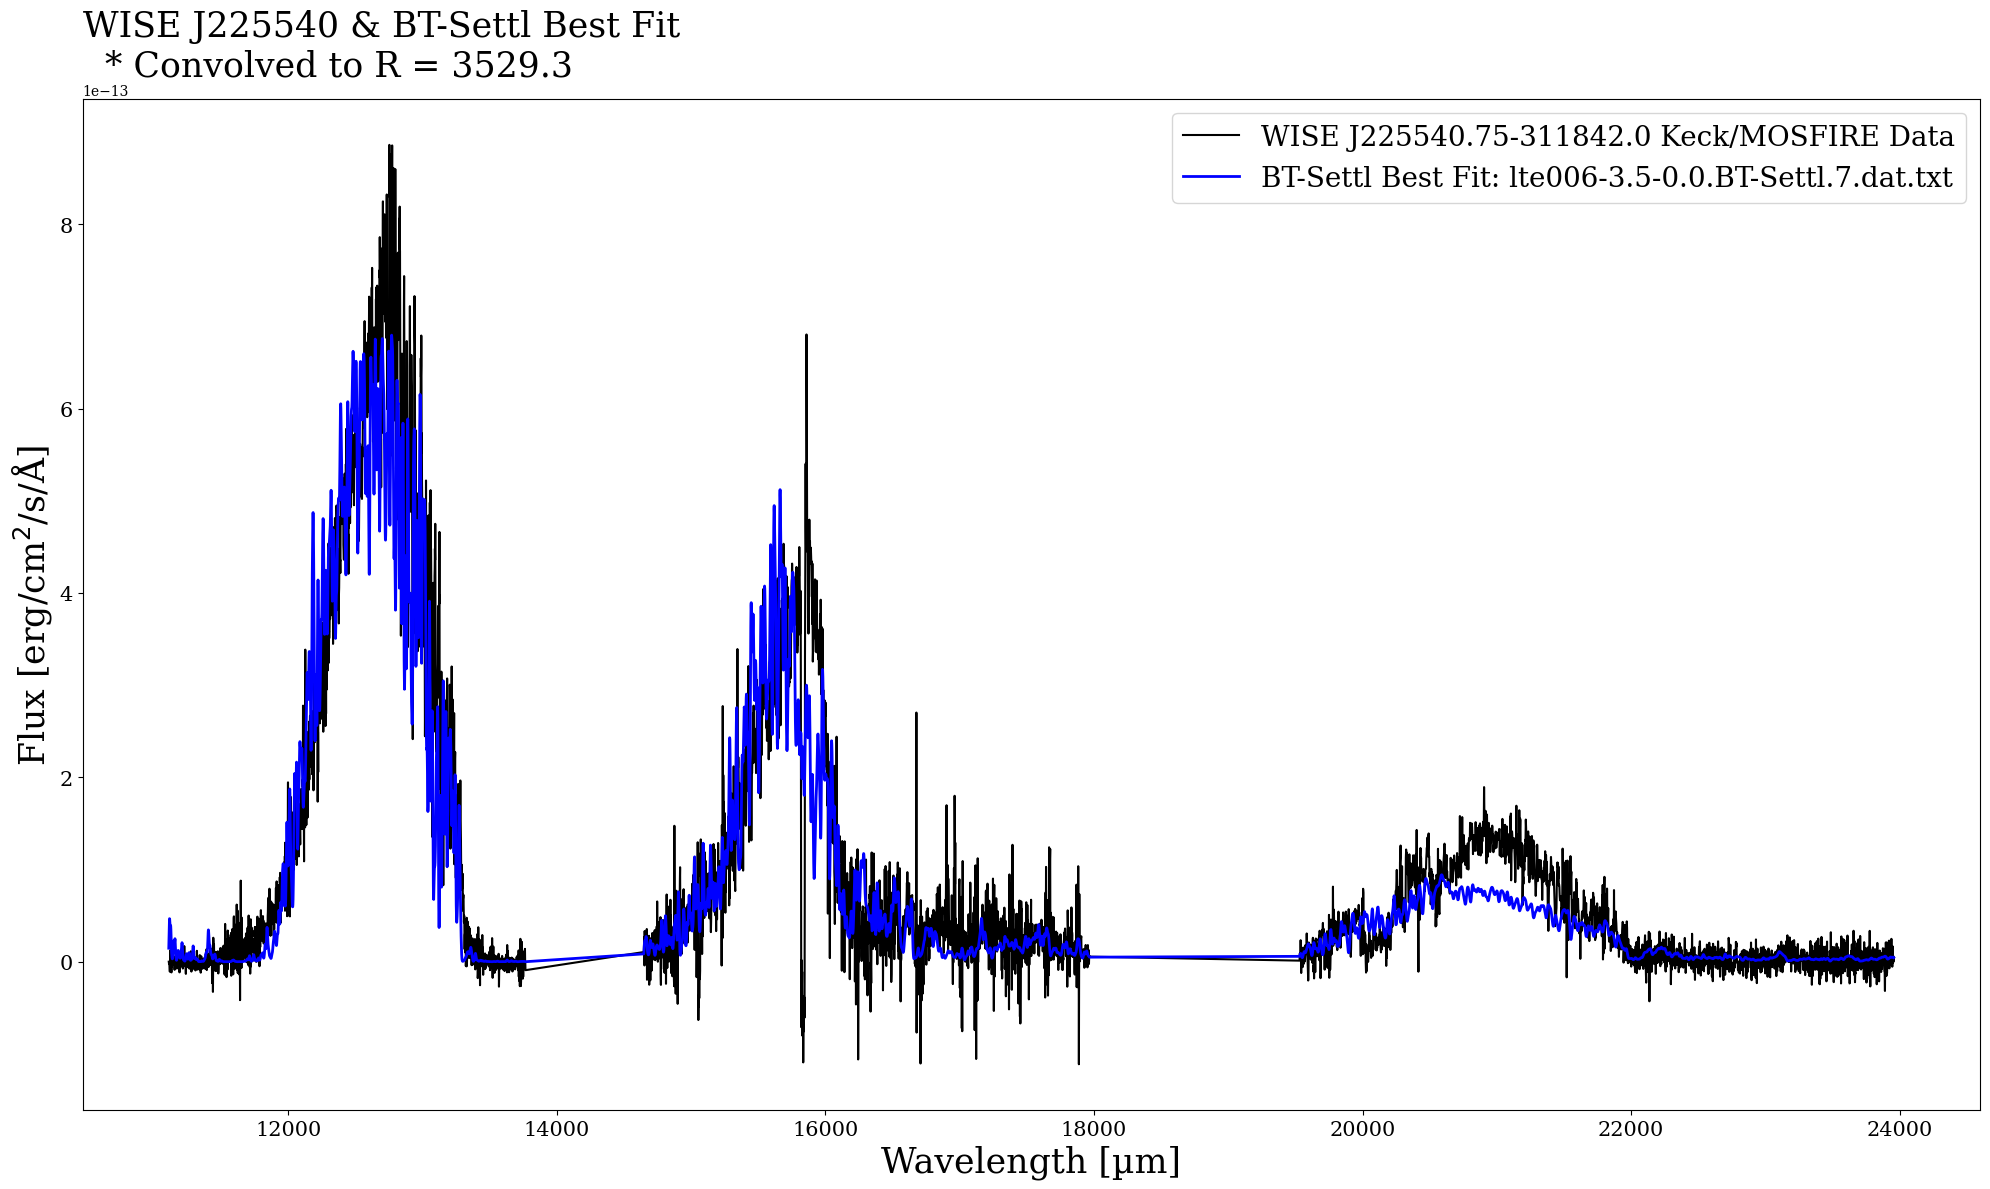

In [288]:
def bestfit_bt(obs_path, mod_path, t, res, modelname):
    '''
    This function takes the observation file path and the model file path, defines the observation wavelength grid,
    convolves the model wavelengths onto that grid, finds the best fit, and plots the observations and best fit together.
    I wish it was more generally parametized, but C'est la vie.
    * Parameters:
        * obs_path: str - the file path to the observed data (pre-defined)
        * mod_path: str - the file path to the model data (pre-defined)
        * t: str - the given name of the observed target (pre-defined)
        * res: int - the instrument resolution for the models to be convolved to (pre-defined)
        * modelname: int - the given name of the model in use (i.e., BT-Settl, ATMO, etc.)
    * Returns:
        * Cmin: arr - the minimum C value of the fit
        * Gmin: int - the minimum G value of the fit
        * bestmodel: str - the file path for the best fit model
        * plot: plot - observational data and the best fit model plotted together
    * Notes:
        * Built to work in tandem with convolve_v2()
        * Data files should be shaped as (wavelength, flux, uncertainty (optional))
        * bestfit_bt is written to work with any models[i].txt file and will plot the best fit in blue.
        * Needs numpy as np, matplotlib.pyplot as plt, and os, glob from glob
    '''
    ## Read in and sort the observational data, and define the resolution for convolve()
    obs = np.loadtxt(obs_path)
    wave_obs = obs[:, 0]
    flux_obs = obs[:, 1]
    unc_obs = obs[:, 2]

    ## Define the full file path to the models
    models = glob(os.path.join(mod_path, '*.txt'))
    spec = models

    ## Define the C and G grids and loop through the models to interpolate and convolve them
    C = np.zeros(len(models))
    G = np.zeros(len(models))
    low_mod = np.zeros((len(models), 2, (len(wave_obs))))
                           
    for i in range(len(models)):
        data = np.loadtxt(models[i])
        wave = np.where((data[:, 0] > wave_obs[0]) & (data[:, 0] < wave_obs[-1]))

        wl = data[wave, 0][0]
        flux = data[wave, 1][0] * 1e4

        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod[i, :, :] = convolve_v2(range_data, R, 1)

        C[i] = (np.nansum((low_mod[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod[i, 1, :] ** 2 / unc_obs ** 2))
        G[i] = np.nansum(((flux_obs - C[i] * low_mod[i, 1, :]) / unc_obs) ** 2)

    ## Calculate the minima in C and G
    Gmin = np.min(G)
    where_Gmin = np.where(G == Gmin)
    Cmin = C[where_Gmin]

    ## Index minG to the correct model
    modindex = int(where_Gmin[0])
    bestfit = np.loadtxt(models[modindex])
    bestmodel = models[modindex]

    ## Print the minimum C and G values and the best fit model
    print(f'Minimum C value:         {Cmin}')
    print(f'Minimum G value:         {Gmin}')
    print(f'Best fit {modelname} model: {bestmodel}')

    ## Write the best-fit data to a .txt file
    outfile = f'{modelname}_data{[modindex]}.txt'
    np.savetxt(outfile, [low_mod[modindex, 0, :], low_mod[modindex, 1, :] * Cmin])

    ## Plot the best fit model with the observational data
    plt.figure(figsize = (20, 12))
    
    plt.plot(wave_obs, flux_obs, color = 'black', label = f'{target} Keck/MOSFIRE Data')
    plt.plot(low_mod[modindex, 0, :], low_mod[modindex, 1, :] * Cmin, color = 'blue', linewidth = 2, label = f'{modelname} Best Fit: {bestmodel[69:]}')

    plt.title(t + f' & {modelname} Best Fit\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    plt.xlabel('Wavelength [µm]', fontsize = 25)
    plt.ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(loc = 'upper right', fontsize = 20, fancybox = True)
    #plt.annotate(f'{bestmodel[69:]}:\n  * t$_e$$_f$$_f$ = 600 K\n  * logg = 3.5\n  * metallicity = 0\n  * alpha = 0\n\n  * Minimum C value: {Cmin}\n  * Minimum G value: {Gmin}', (18000, 2.5e-13), fontsize = 25)
    plt.tight_layout()
    #plt.savefig('WISE + BT-Settl Best Fit')

    return

bestfit_bt(file_name, bt_path, target_short, R, 'BT-Settl') 

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_25330/3932407163.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex = int(where_Gmin[0])


Minimum C value:     [0.00090198]
Minimum G value:     0.07197701000461924
Best fit ATMO model: /Users/bseamons/Documents/Research/atmo_models/spec_jwst_noPH3_t400_g4.5_p0_kg_g1.25.dat


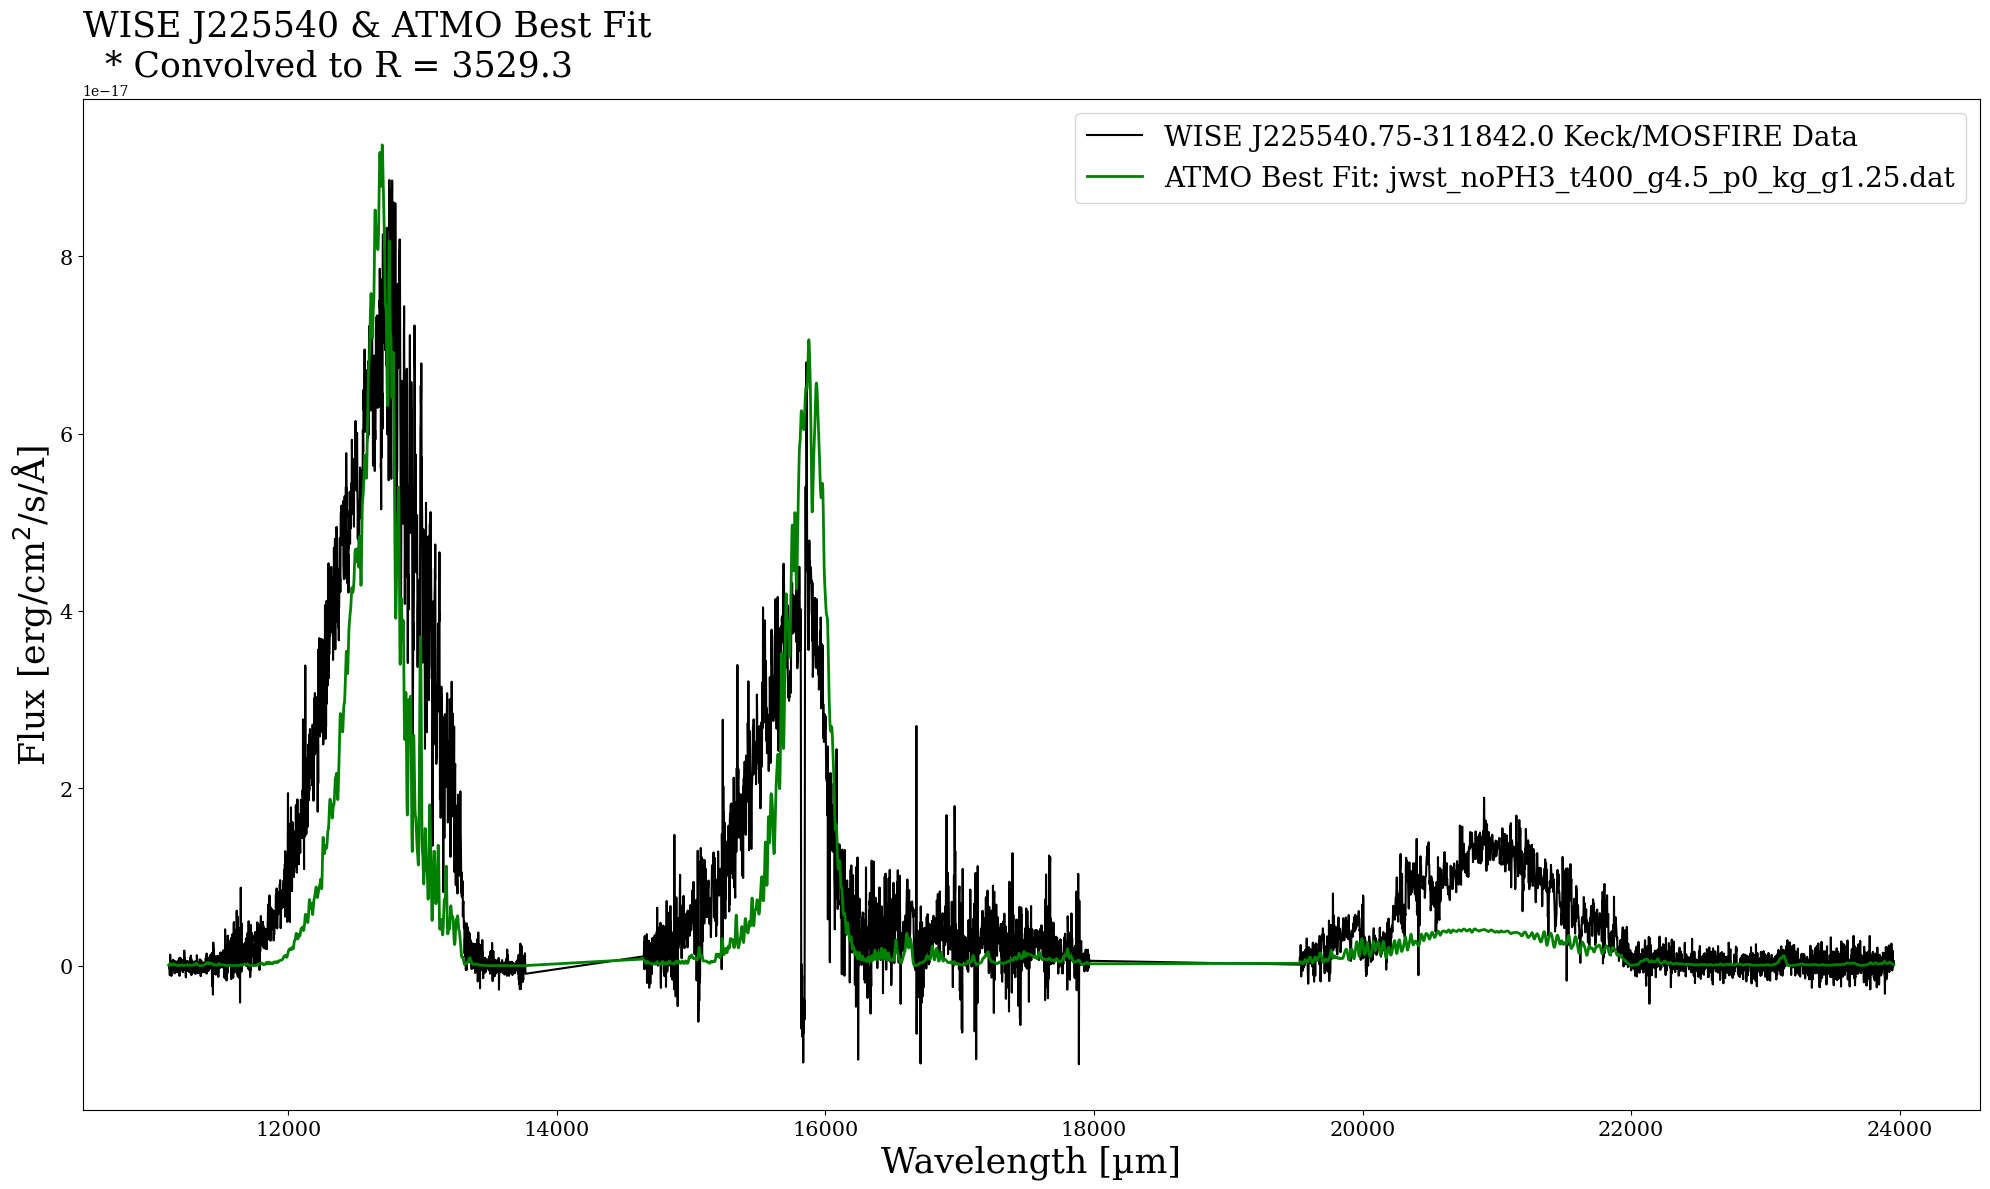

In [292]:
def bestfit_atmo(obs_path, mod_path, t, res, modelname):
    '''
    This function takes the observation file path and the model file path, defines the observation wavelength grid,
    convolves the model wavelengths onto that grid, finds the best fit, and plots the observations and best fit together.
    I wish it was more generally parametized, but C'est la vie.
    * Parameters:
        * obs_path: str - the file path to the observed data (pre-defined)
        * mod_path: str - the file path to the model data (pre-defined)
        * t: str - the given name of the observed target (pre-defined)
        * res: int - the instrument resolution for the models to be convolved to (pre-defined)
        * modelname: int - the given name of the model in use (i.e., BT-Settl, ATMO, etc.)
    * Returns:
        * Cmin: arr - the minimum C value of the fit
        * Gmin: int - the minimum G value of the fit
        * bestmodel: str - the file path for the best fit model
        * plot: plot - observational data and the best fit model plotted together
    * Notes:
        * Built to work in tandem with convolve_v2()
        * Data files should be shaped as (wavelength, flux, uncertainty (optional))
        * bestfit_atmo is written to work with any models[i].dat file and will plot the best fit in green.
        * Needs numpy as np, matplotlib.pyplot as plt, and os, glob from glob
    '''
    ## Read in and sort the observational data, and define the resolution for convolve()
    obs = np.loadtxt(obs_path)
    wave_obs = obs[:, 0]
    flux_obs = obs[:, 1] * 1e-4
    unc_obs = obs[:, 2]

    ## Define the full file path to the models
    models = glob(os.path.join(mod_path, '*.dat'))
    spec = models

    ## Define the C and G grids and loop through the models to interpolate and convolve them
    C = np.zeros(len(models))
    G = np.zeros(len(models))
    low_mod = np.zeros((len(models), 2, (len(wave_obs))))
    
    output_files = []
    for i in range(len(models)):
        data = np.loadtxt(models[i])

        wl = data[:, 0] * 1e4
        flux = data[:,1] * 1e4

        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod[i, :, :] = convolve_v2(range_data, R, 1)

        C[i] = (np.nansum((low_mod[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod[i, 1, :] ** 2 / unc_obs ** 2))
        G[i] = np.nansum(((flux_obs[i] - C[i] * low_mod[i, 1, :]) / unc_obs[i]) ** 2)

    ## Calculate the minima in C and G
    Gmin = np.min(G)
    where_Gmin = np.where(G == Gmin)
    Cmin = C[where_Gmin]

    ## Index minG to the correct model
    modindex = int(where_Gmin[0])
    bestfit = np.loadtxt(models[modindex])
    bestmodel = models[modindex]

    ## Print the minimum C and G values and the best fit model
    print(f'Minimum C value:     {Cmin}')
    print(f'Minimum G value:     {Gmin}')
    print(f'Best fit {modelname} model: {bestmodel}')

    ## Write the best-fit data to a .txt file
    outfile = f'{modelname}_data{[modindex]}.txt'
    np.savetxt(outfile, [low_mod[modindex, 0, :], low_mod[modindex, 1, :] * Cmin])

    ## Plot the best fit model with the observational data
    plt.figure(figsize = (20, 12))
    
    plt.plot(wave_obs, flux_obs, color = 'black', label = f'{target} Keck/MOSFIRE Data')
    plt.plot(low_mod[modindex, 0, :], low_mod[modindex, 1, :] * Cmin, color = 'green', linewidth = 2, label = f'{modelname} Best Fit: {bestmodel[52:]}')

    plt.title(t + f' & {modelname} Best Fit\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    plt.xlabel('Wavelength [µm]', fontsize = 25)
    plt.ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(loc = 'upper right', fontsize = 20, fancybox = True)
    #plt.annotate(f'{bestmodel[52:]}:\n  * t$_e$$_f$$_f$ = 400 K\n  * logg = 4.5\n\n  * Minimum C value: {Cmin}\n  * Minimum G value: {Gmin}', (18000, 2.5e-17), fontsize = 25)
    plt.tight_layout()
    #plt.savefig('WISE + ATMO Best Fit')

    return

bestfit_atmo(file_name, atmo_path, target_short, R, 'ATMO')

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_25330/1598883329.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex = int(where_Gmin[0])


Minimum C value:       [3.90996699e-21]
Minimum G value:       0.03722101534812992
Best fit SpeX spectra: /Users/bseamons/Documents/Research/SpeX_archived_spectra/spex-prism_2MASSIJ0937347+293142_20040311_T6p.spex.txt


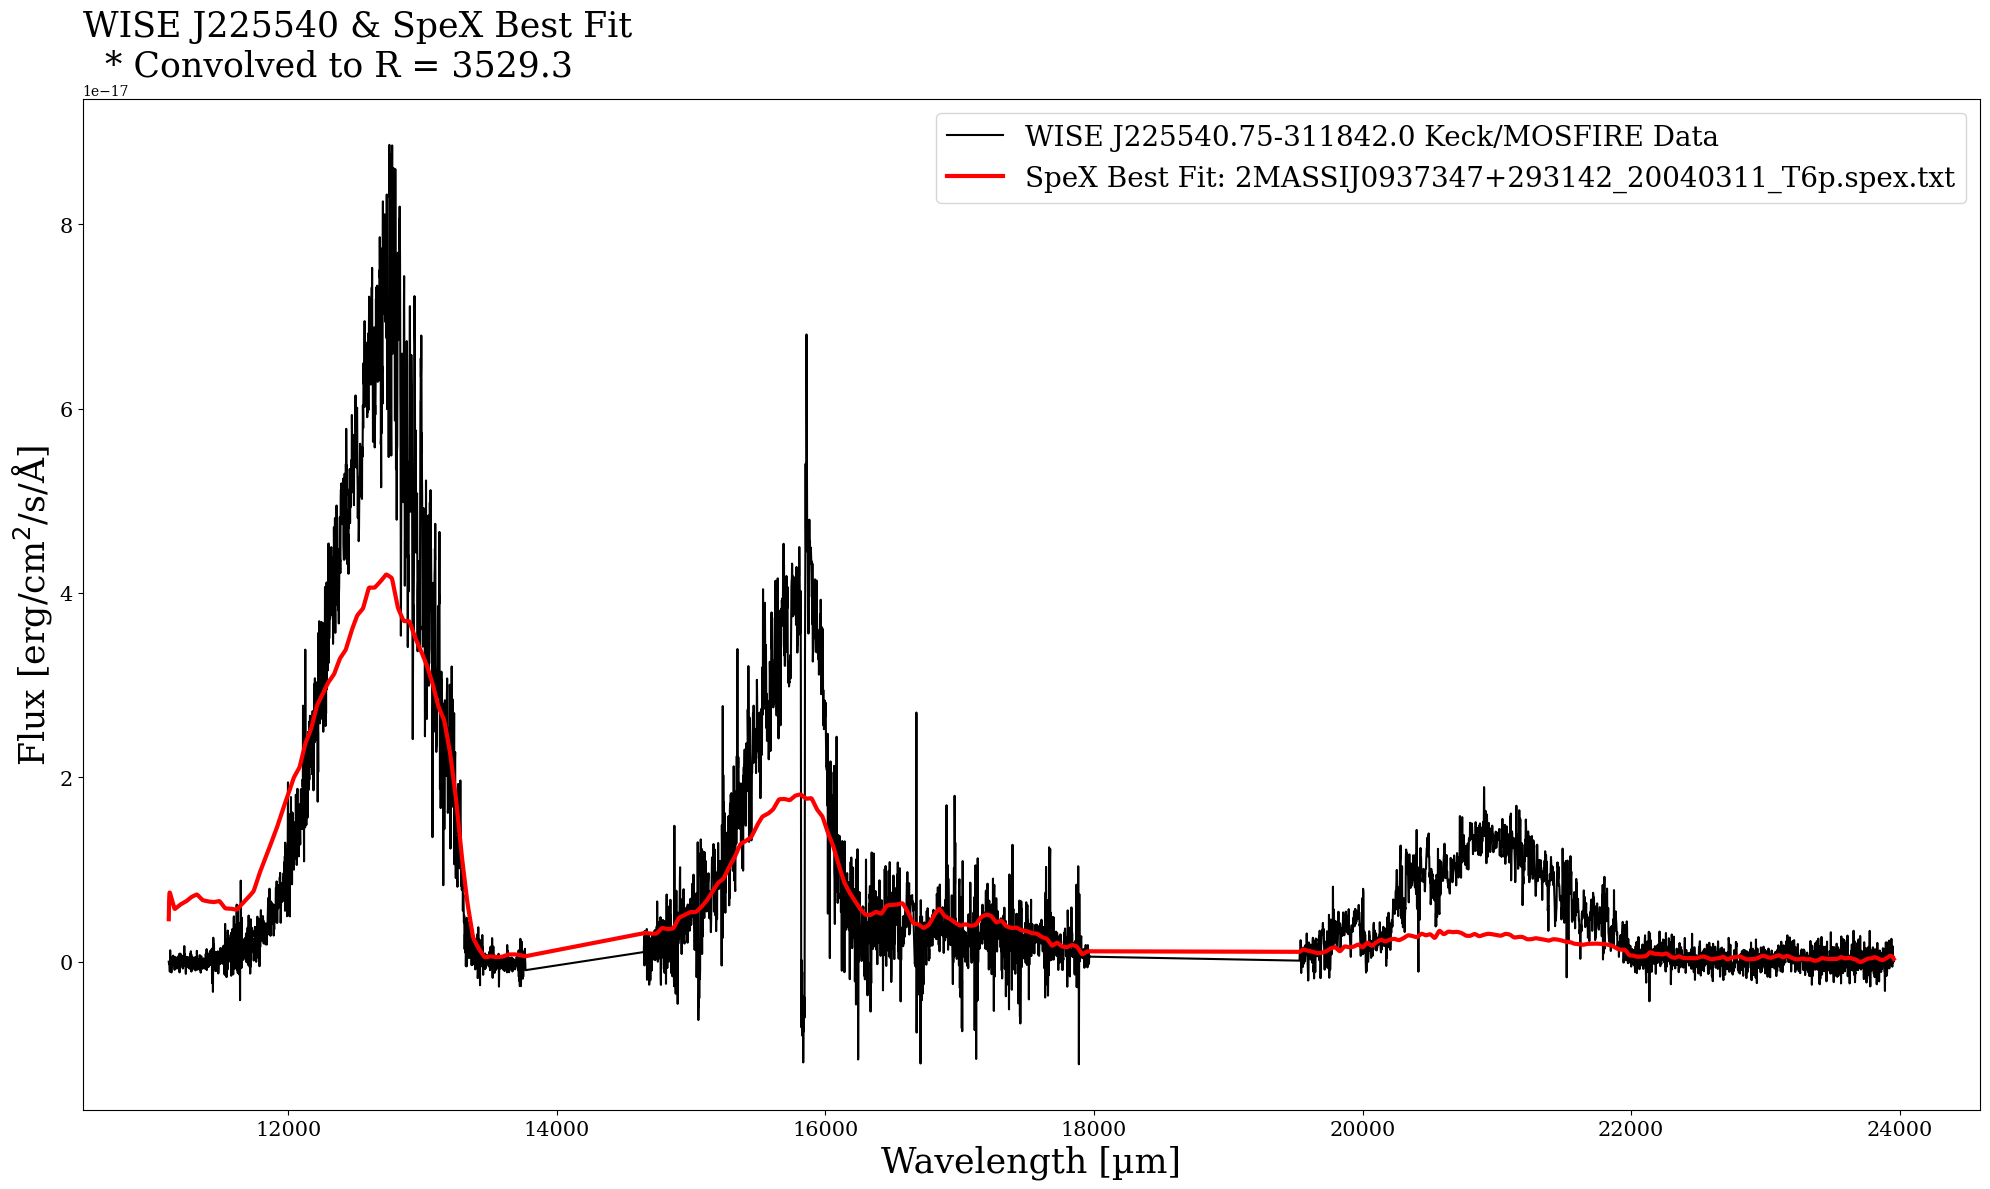

In [297]:
def bestfit_spex(obs_path, mod_path, t, res, modelname):
    '''
    This function takes the observation file path and the model file path, defines the observation wavelength grid,
    convolves the model wavelengths onto that grid, finds the best fit, and plots the observations and best fit together.
    I wish it was more generally parametized, but C'est la vie.
    * Parameters:
        * obs_path: str - the file path to the observed data (pre-defined)
        * mod_path: str - the file path to the model data (pre-defined)
        * t: str - the given name of the observed target (pre-defined)
        * res: int - the instrument resolution for the models to be convolved to (pre-defined)
        * modelname: int - the given name of the model in use (i.e., BT-Settl, ATMO, etc.)
    * Returns:
        * Cmin: arr - the minimum C value of the fit
        * Gmin: int - the minimum G value of the fit
        * bestmodel: str - the file path for the best fit model
        * plot: plot - observational data and the best fit model plotted together
    * Notes:
        * Built to work in tandem with convolve_v2()
        * Data files should be shaped as (wavelength, flux, uncertainty (optional))
        * bestfit_spex is written to work with any models[i].txt file and will plot the best fit in red.
        * Needs numpy as np, matplotlib.pyplot as plt, and os, glob from glob
    '''
    ## Read in and sort the observational data, and define the resolution for convolve()
    obs = np.loadtxt(obs_path)
    wave_obs = obs[:, 0]
    flux_obs = obs[:, 1] * 1e-4
    unc_obs = obs[:, 2]

    ## Define the full file path to the models
    models = glob(os.path.join(mod_path, '*.txt'))
    spec = models

    ## Define the C and G grids and loop through the models to interpolate and convolve them
    C = np.zeros(len(models))
    G = np.zeros(len(models))
    low_mod = np.zeros((len(models), 2, (len(wave_obs))))

    for i in range(len(models)):
        data = np.loadtxt(models[i])

        wl = data[:, 0] * 1e4
        flux = data[:,1] * 1e4

        interp_flux = np.interp(wave_obs, wl, flux)
        range_data = np.vstack([wave_obs, interp_flux])
        low_mod[i, :, :] = convolve_v2(range_data, R, 1)

        C[i] = (np.nansum((low_mod[i, 1, :] * flux_obs) / unc_obs ** 2)) / (np.nansum(low_mod[i, 1, :] ** 2 / unc_obs ** 2))
        G[i] = np.nansum(((flux_obs[i] - C[i] * low_mod[i, 1, :]) / unc_obs[i]) ** 2)

    ## Calculate the minima in C and G
    Gmin = np.min(G)
    where_Gmin = np.where(G == Gmin)
    Cmin = C[where_Gmin]

    ## Index minG to the correct model
    modindex = int(where_Gmin[0])
    bestfit = np.loadtxt(models[modindex])
    bestmodel = models[modindex]

    ## Print the minimum C and G values and the best fit model
    print(f'Minimum C value:       {Cmin}')
    print(f'Minimum G value:       {Gmin}')
    print(f'Best fit {modelname} spectra: {bestmodel}')

    ## Write the best-fit data to a .txt file
    outfile = f'{modelname}_data{[modindex]}.txt'
    np.savetxt(outfile, [low_mod[modindex, 0, :], low_mod[modindex, 1, :] * Cmin])
    
    ## Plot the best fit model with the observational data
    plt.figure(figsize = (20, 12))
    
    plt.plot(wave_obs, flux_obs, color = 'black', label = f'{target} Keck/MOSFIRE Data')
    plt.plot(low_mod[modindex, 0, :], low_mod[modindex, 1, :] * Cmin, color = 'red', linewidth = 3, label = f'{modelname} Best Fit: {bestmodel[68:]}')

    plt.title(t + f' & {modelname} Best Fit\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
    plt.xlabel('Wavelength [µm]', fontsize = 25)
    plt.ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.legend(loc = 'upper right', fontsize = 20, fancybox = True)
    #plt.annotate(f'{bestmodel[68:]}:\n  * Optical spectral type: T7\n  * NIR spectral type: T6p\n  * J mag = 14.648\n  * H mag = 14.703\n  * Ks mag = 15.267\n  * Minimum C value: {Cmin}\n  * Minimum G value: {Gmin}', (17300, 2.5e-17), fontsize = 15)
    plt.tight_layout()
    #plt.savefig('WISE + SpeX Best Fit')

    return

bestfit_spex(file_name, spex_path, target_short, R, 'SpeX')

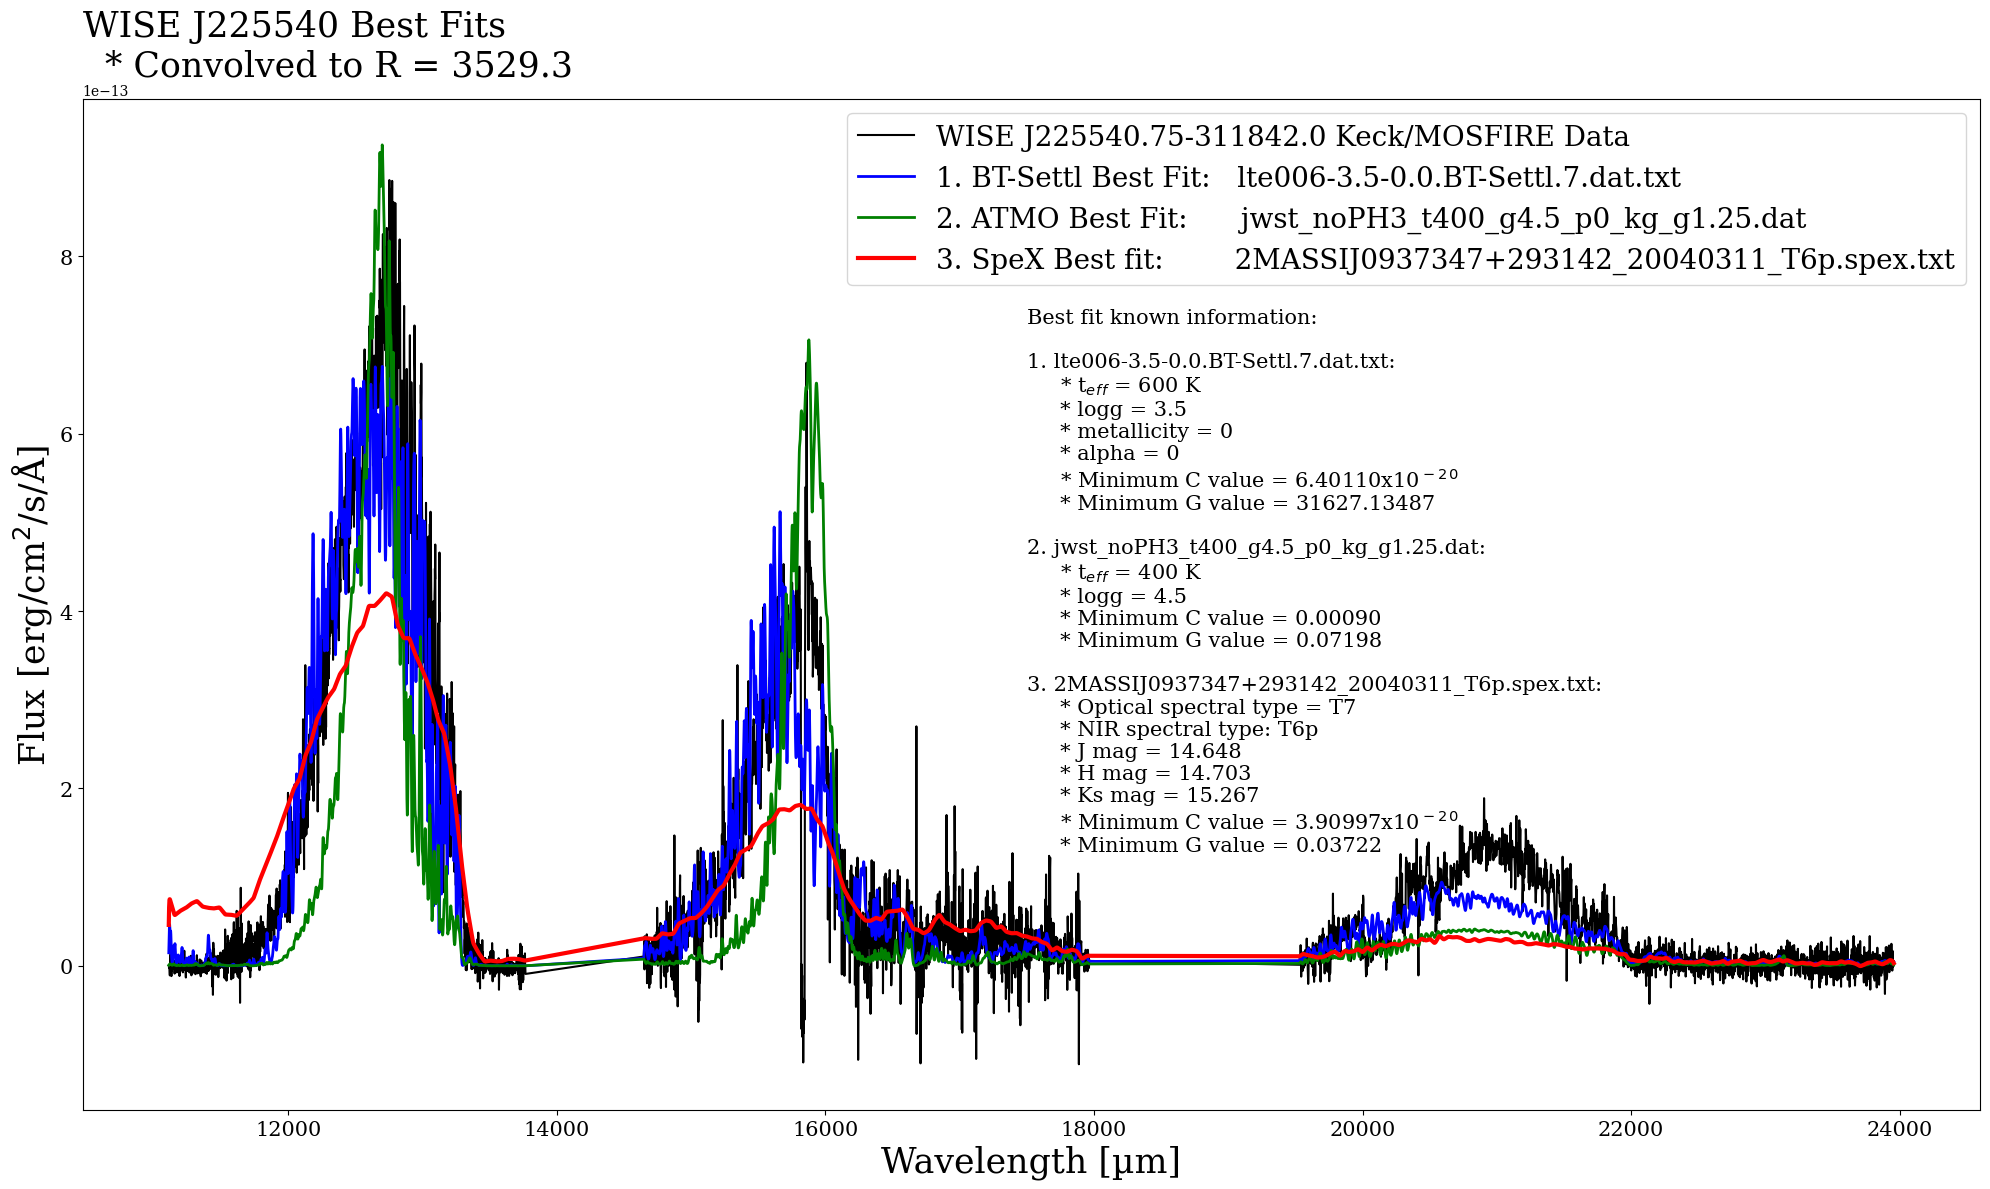

In [275]:
bdat = np.loadtxt('BT-Settl_data[27].txt')
bwave = bdat[0, :]
bflux = bdat[1, :]

adat = np.loadtxt('ATMO_data[5].txt')
awave = adat[0, :]
aflux = adat[1, :]

sdat = np.loadtxt('SpeX_data[20].txt')
swave = sdat[0, :]
sflux = sdat[1, :]

string1 = f'{bt_models[27][69:]}:\n     * t$_e$$_f$$_f$ = 600 K\n     * logg = 3.5\n     * metallicity = 0\n     * alpha = 0\n     * Minimum C value = 6.40110x10$^-$$^2$$^0$\n     * Minimum G value = 31627.13487\n\n'
string2 = f'{atmo_models[5][52:]}:\n     * t$_e$$_f$$_f$ = 400 K\n     * logg = 4.5\n     * Minimum C value = 0.00090\n     * Minimum G value = 0.07198\n\n'
string3 = f'{spex_models[20][68:]}:\n     * Optical spectral type = T7\n     * NIR spectral type: T6p\n     * J mag = 14.648\n     * H mag = 14.703\n     * Ks mag = 15.267\n     * Minimum C value = 3.90997x10$^-$$^2$$^0$\n     * Minimum G value = 0.03722'

plt.figure(figsize = (20, 12))

plt.plot(wave, flux, color = 'black', label = f'{target} Keck/MOSFIRE Data')
plt.plot(bwave, bflux, color = 'blue', linewidth = 2, label = f'1. BT-Settl Best Fit:   {bt_models[27][69:]}')
plt.plot(awave, aflux * 1e4, color = 'green', linewidth = 2, label = f'2. ATMO Best Fit:      {atmo_models[5][52:]}')
plt.plot(swave, sflux * 1e4, color = 'red', linewidth = 3, label = f'3. SpeX Best fit:        {spex_models[20][68:]}')

plt.title(f'{target_short} Best Fits\n  * Convolved to R = {np.round(R, 1)}', loc = 'left', fontsize = 25)
plt.xlabel('Wavelength [µm]', fontsize = 25)
plt.ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc = 'upper right', fontsize = 20, fancybox = True)
plt.annotate(f'Best fit known information:\n\n1. {string1}2. {string2}3. {string3}', (17500, 1.3e-13), fontsize = 15)
plt.tight_layout()
#plt.savefig('WISE + All Best Fits')